In [10]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
base_dir = "./archive/brain_tumor_dataset"

In [8]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'valid')

print(f'There are {len(os.listdir(train_dir))} classes in the training directory')
print(f'There are {len(os.listdir(test_dir))} classes in the test directory')

print(f'Train Classes : {(os.listdir(train_dir))}')
print(f'Test Classes : {(os.listdir(test_dir))}')

train_no = os.path.join(train_dir, 'no')
train_yes = os.path.join(train_dir, 'yes')

test_no = os.path.join(test_dir, 'no')
test_yes = os.path.join(test_dir, 'yes')

print(f'There are {len(os.listdir(train_no))} not tumor image in the training directory')
print(f'There are {len(os.listdir(train_yes))} tumor image in the training directory')

print(f'There are {len(os.listdir(test_no))} not tumor image in the test directory')
print(f'There are {len(os.listdir(test_yes))} tumor image in the test directory')

print(f'There are {len(os.listdir(train_yes)) + len(os.listdir(train_no))} images in the training directory')
print(f'There are {len(os.listdir(test_yes)) + len(os.listdir(test_no))} images in the test directory')

There are 2 classes in the training directory
There are 2 classes in the test directory
Train Classes : ['no', 'yes']
Test Classes : ['no', 'yes']
There are 72 not tumor image in the training directory
There are 120 tumor image in the training directory
There are 26 not tumor image in the test directory
There are 35 tumor image in the test directory
There are 192 images in the training directory
There are 61 images in the test directory


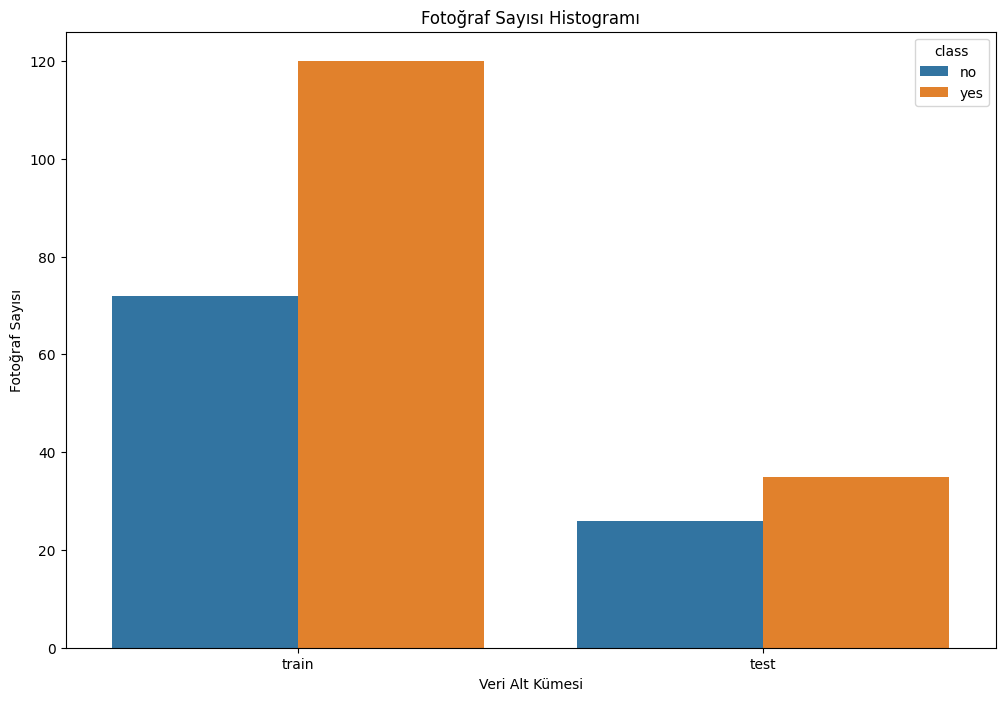

In [12]:
data = [
    {"subset": "train", "class": "no", "count": 72},
    {"subset": "train", "class": "yes", "count": 120},
    {"subset": "test", "class": "yes", "count": 35},
    {"subset": "test", "class": "no", "count": 26}
]

df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))
sns.barplot(x="subset", y="count", hue="class", data=df)
plt.title("Fotoğraf Sayısı Histogramı")
plt.xlabel("Veri Alt Kümesi")
plt.ylabel("Fotoğraf Sayısı")
plt.show()


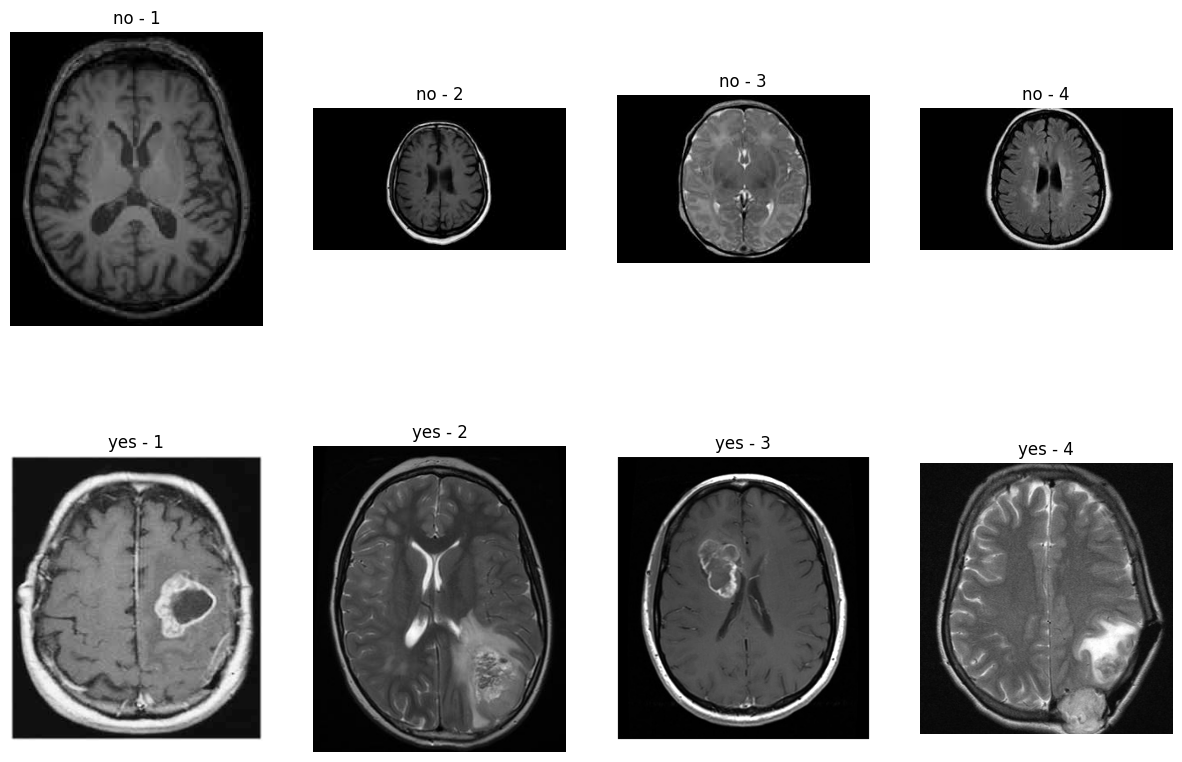

In [13]:
class_names = ['no', 'yes']
fig, axs = plt.subplots(len(class_names), 4, figsize=(15, 10))

for i, class_name in enumerate(class_names):
    for j in range(4):
        subset_path = os.path.join(base_dir, "train", class_name)
        img_name = os.listdir(subset_path)[j]
        img_path = os.path.join(subset_path, img_name)
        
        # Load and add the image to the subplot
        img = plt.imread(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(f"{class_name} - {j+1}")
        axs[i, j].axis('off')  # Turn off axes

# Show the plot
plt.show()

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   rotation_range = 40,
                                   featurewise_center=False,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   vertical_flip = True
                                   )
train_generator = train_datagen.flow_from_directory(
    "archive/brain_tumor_dataset/train",
    target_size = (300,300),
    batch_size = 20,
    class_mode = 'binary'
)

Found 192 images belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    "archive/brain_tumor_dataset/valid",
    target_size = (300,300),
    batch_size = 10,
    class_mode = 'binary'
)

Found 61 images belonging to 2 classes.


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 256, activation = 'relu'),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1024, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.98):
      print(f"\n Exitting due to enough accuracy...")
      self.model.stop_training = True

In [19]:
callbacks = myCallback()

In [20]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss = "binary_crossentropy",
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'],
              )

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch = 8,
    callbacks=[callbacks],
    epochs = 100,
    validation_data = test_generator,
    validation_steps=8,
    verbose = 1
)

Epoch 1/100
8/8 [==============================] - 4s 571ms/step - loss: 0.5222 - accuracy: 0.7961
Epoch 2/100
8/8 [==============================] - 4s 565ms/step - loss: 0.5616 - accuracy: 0.7434
Epoch 3/100
8/8 [==============================] - 4s 501ms/step - loss: 0.5077 - accuracy: 0.7566
Epoch 4/100
8/8 [==============================] - 4s 509ms/step - loss: 0.5603 - accuracy: 0.7039
Epoch 5/100
8/8 [==============================] - 4s 536ms/step - loss: 0.5127 - accuracy: 0.7237
Epoch 6/100
8/8 [==============================] - 4s 543ms/step - loss: 0.5205 - accuracy: 0.7368
Epoch 7/100
8/8 [==============================] - 4s 495ms/step - loss: 0.4534 - accuracy: 0.7303
Epoch 8/100
8/8 [==============================] - 4s 498ms/step - loss: 0.5385 - accuracy: 0.7697
Epoch 9/100
8/8 [==============================] - 4s 544ms/step - loss: 0.5000 - accuracy: 0.7688
Epoch 10/100
8/8 [==============================] - 4s 497ms/step - loss: 0.4749 - accuracy: 0.7697
Epoch 11/

In [35]:
model_weight = model.save("brain_tumor_detector.h5")

In [37]:
from tensorflow.keras.models import load_model

model_weight = load_model('brain_tumor_detector.h5')  # Replace 'your_model.h5' with your actual model file


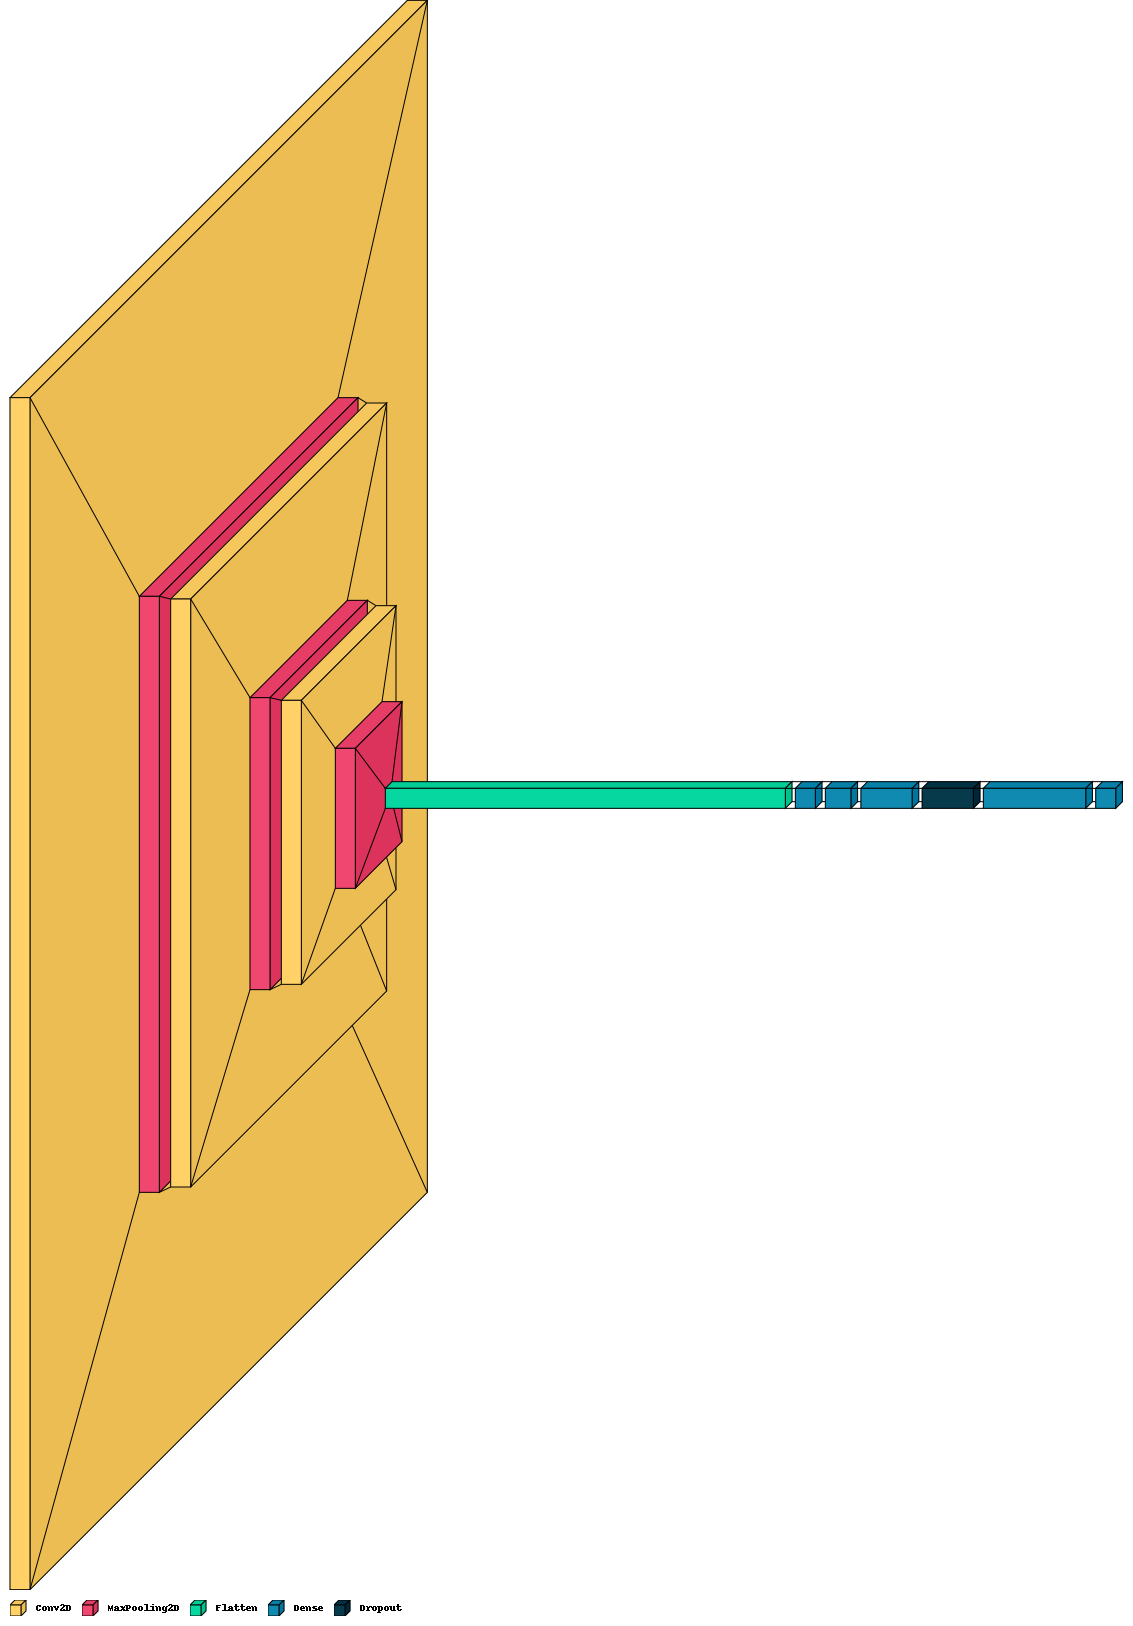

In [38]:
from PIL import ImageFont
import visualkeras

visualkeras.layered_view( model_weight , legend=True )  # font is optional!